# Netscience Collaboration Network

data source: https://networkrepository.com/ca-netscience.php


In [22]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from layout import Layout

### Construct graph from network data

In [23]:
G = nx.read_edgelist("netscience.txt", nodetype=int)
nx.info(G)

'Graph with 379 nodes and 914 edges'

In [24]:
pos = nx.spring_layout(G, dim=3)

In [25]:
layout = Layout(G, pos)

#### Add edge weights

In [26]:
cliques_dict = nx.cliques_containing_node(G, nodes=list(G.nodes))
# convert inner lists to sets for permutation invariant comparison
all_cliques = {node: [set(clique) for clique in cliques] for node, cliques in cliques_dict.items()}

In [27]:
for n1, n2 in G.edges:
    weight = 0
    for clique in all_cliques[n1]:
        if clique in all_cliques[n2]:
            weight += 1 / (len(clique) - 1)
    G[n1][n2]["weight"] = weight

In [28]:
weights = [G[n1][n2]["weight"] for n1, n2 in G.edges]

In [29]:
max_weight = np.max(weights)
min_weight = np.min(weights)

In [30]:
print(max_weight, "should be 4.75")
print(min_weight, "should be 0.125")

2.833333333333333 should be 4.75
0.125 should be 0.125


### Write nodes and edges

In [31]:
max_glow = 255
min_glow = 100

def get_glow(weight):
    k = (max_glow - min_glow) / (max_weight - min_weight)
    d = min_glow - k * min_weight
    return int(k * weight + d)

layout.edge_colors = [(255, 255, 255, get_glow(G[n1][n2]["weight"])) for n1, n2 in G.edges]

In [32]:
layout.node_table

,x,y,z,r,g,b,a,name
0,0.794942,0.651676,0.509812,31,119,180,100,node_0
1,0.740322,0.616059,0.506964,31,119,180,100,node_1
2,0.784636,0.660141,0.518815,31,119,180,100,node_2
3,0.737133,0.547970,0.660331,31,119,180,100,node_3
4,0.687935,0.532711,0.581865,31,119,180,100,node_4
...,...,...,...,...,...,...,...,...
374,0.724698,1.000000,0.268997,31,119,180,100,node_374
375,0.845687,0.733592,0.757676,31,119,180,100,node_375
376,0.841245,0.743160,0.736818,31,119,180,100,node_376
377,0.853435,0.735872,0.743210,31,119,180,100,node_377


In [33]:
layout.edge_table

,i,j,r,g,b,a
0,0,1,255,255,255,121
1,0,2,255,255,255,121
2,1,2,255,255,255,121
3,1,3,255,255,255,126
4,1,4,255,255,255,126
...,...,...,...,...,...,...
909,375,377,255,255,255,107
910,375,378,255,255,255,107
911,376,377,255,255,255,107
912,376,378,255,255,255,107


In [34]:
layout.write(node_file_path="collaboration_nodes.csv", edge_file_path="collaboration_edges.csv")

### Persistent Homology

https://snap.stanford.edu/social2012/papers/carstens-horadam.pdf

In [35]:
filtration = []
thresholds = np.linspace(min_weight, max_weight, len(G))
for threshold in thresholds:
    filter_edge = lambda n1, n2: G[n1][n2]["weight"] >= threshold
    view = nx.subgraph_view(G, filter_edge=filter_edge).copy()
    filtration.append(view)

betti_0 = [nx.number_connected_components(view) for view in filtration]
w_star = thresholds[::-1][np.argmin(betti_0[::-1])]
n_edges = [view.number_of_edges() for view in filtration]

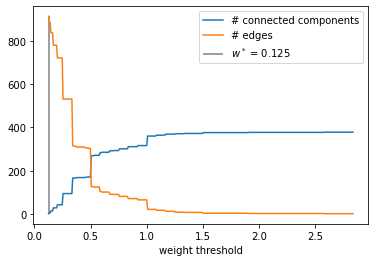

In [36]:
plt.plot(thresholds, betti_0, label="# connected components")
plt.plot(thresholds, n_edges, label="# edges")
plt.vlines(w_star, 0, n_edges[0], color="black", alpha=0.5, label=fr"$w^*$ = {w_star:.3g}")
plt.xlabel("weight threshold")
plt.legend()
plt.show()